In [1]:
!pip install fasttext
!pip install nltk
# !pip install memory_profiler
# !pip install -U mkl
# !pip install -U nump
# !pip install --upgrade tensorflow
# !pip install --upgrade keras

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


# Экспериментальная часть

In [159]:
import numpy as np
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import string
from scipy.spatial.distance import jensenshannon
import scipy.io as sio
from scipy.special import rel_entr, kl_div
from scipy.stats import entropy, ks_2samp
from scipy.spatial.distance import jensenshannon
from scipy.special import rel_entr
# from skmultiflow.drift_detection import DDM, PageHinkley, ADWIN
# from skmultiflow.data import Conc>eptDriftStream
import datetime
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt
import os
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Embedding, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import to_categorical
# import tensorflow as tf
from sys import getsizeof
from sys import getrefcount
import gc
import fasttext.util
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow import keras
import random
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import joblib
import tensorflow as tf
from itertools import product
# import memory_profiler

In [4]:
# fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')
samples_number = 7

### Подготовка данных

In [5]:
# # porter_stemmer = nltk.stem.PorterStemmer()
# # tok = CountVectorizer().build_tokenizer()
# df_all = pd.read_csv('Electronics_5.csv')
# df_all.reviewTime = pd.to_datetime(df_all.reviewTime, format="%m %d, %Y")
# df_all = df_all.sort_values(by = 'reviewTime').reset_index(drop = True)
# df_all["bin_label"] = df_all.overall > 3
# df_all['label'] = df_all.overall.apply(lambda x: 2 if x == 3 else (1 if x < 3 else 3))
# df_all["words"] = list(map(lambda elem: (" ").join(map(lambda s: (porter_stemmer.stem(s)), elem)).lower().translate(str.maketrans('', '', string.punctuation)), map(lambda wrds: tok(wrds), df_all.reviewText.apply(lambda x: np.str_(x)))))

In [6]:
# df_by_years = {}
# for year in df_all.reviewTime.dt.year.unique().tolist():
#     df_by_years[year] = df_all[df_all.reviewTime.dt.year == year].reset_index(drop = True)
#     print(year, len(df_by_years[year]))
#     print(df_by_years[year].bin_label.value_counts(), '\n')

In [7]:
# skf = StratifiedKFold(n_splits=samples_number)
# for year in range(2007, 2015):
#     data_tmp = df_by_years[year].sample(35000)
#     data_list = []
#     index = 0
#     for train_index, test_index in skf.split(data_tmp.words, data_tmp.label):
#         data = data_tmp.iloc[test_index]
#         data[['words', 'label']].to_csv('data/{0}_{1}.csv'.format(year, index))
#         index += 1
#     print(year)
# del df_by_years
# del df_all
# del porter_stemmer
# del tok
# gc.collect()

### Вычисления

In [141]:
df_accuracy = pd.DataFrame(np.zeros([2015-2007, (2015-2007)*samples_number]), index=range(2007, 2015), columns=pd.MultiIndex.from_product([range(2007, 2015), range(samples_number)]))

df_tvd_lstm = df_accuracy.copy()
df_js_lstm = df_accuracy.copy()
df_ks_lstm = df_accuracy.copy()
df_kl_lstm = df_accuracy.copy()

df_tvd_tfidf = df_accuracy.copy()
df_js_tfidf = df_accuracy.copy()
df_ks_tfidf = df_accuracy.copy()
df_kl_tfidf = df_accuracy.copy()

df_tvd_count = df_accuracy.copy()
df_js_count = df_accuracy.copy()
df_ks_count = df_accuracy.copy()
df_kl_count = df_accuracy.copy()

df_tvd_prob = df_accuracy.copy()
df_js_prob = df_accuracy.copy()
df_ks_prob = df_accuracy.copy()
df_kl_prob = df_accuracy.copy()

df_tvd_Y = df_accuracy.copy()
df_js_Y = df_accuracy.copy()
df_ks_Y = df_accuracy.copy()
df_kl_Y = df_accuracy.copy()


df_perc_no_zero = df_accuracy.copy()
df_f1 = df_accuracy.copy()
measurements = {'metrics': {'f1': df_f1, 'accuracy': df_accuracy},
                'lstm': {'tvd': df_tvd_lstm, 'js': df_js_lstm, 'ks': df_ks_lstm, 'kl': df_kl_lstm},
                'tfidf': {'tvd': df_tvd_tfidf, 'js': df_js_tfidf, 'ks': df_ks_tfidf, 'kl': df_kl_tfidf},
                'count': {'tvd': df_tvd_count, 'js': df_js_count, 'ks': df_ks_count, 'kl': df_kl_count},
                'prob': {'tvd': df_tvd_prob, 'js': df_js_prob, 'ks': df_ks_prob, 'kl': df_kl_prob},
                'Y': {'tvd': df_tvd_Y, 'js': df_js_Y, 'ks': df_ks_Y, 'kl': df_kl_Y},
                'perc_no_zero': df_perc_no_zero
               }
measurements['metrics']['accuracy']
df_accuracy

2007                                                   2008          \
          0      1       2       3       4       5       6       0       1   
2007  0.701  0.732  0.7132  0.6064  0.6992  0.7616  0.7096  0.7096  0.7206   
2008  0.000  0.000  0.0000  0.0000  0.0000  0.0000  0.0000  0.7268  0.7396   
2009  0.000  0.000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
2010  0.000  0.000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
2011  0.000  0.000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
2012  0.000  0.000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
2013  0.000  0.000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
2014  0.000  0.000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   

              ...    2013                    2014                          \
           2  ...       4       5       6       0       1       2       3   
2007  0.7188  ...  0.7350  0.7870  0.7516  0.7606  0.7632  0.7568  0.6278   
2008  0.7542  ...  0.7372  0.7444  0.7286  0.7668  0.7766  0.7912  0.7198   
2009  0.0000  ...  0.7178  0.7956  0.7730  0.7410  0.7354  0.7172  0.7362   
2010  0.0000  ...  0.8154  0.7516  0.7644  0.7666  0.7630  0.8100  0.7140   
2011  0.0000  ...  0.6924  0.6958  0.7500  0.7132  0.7506  0.7264  0.6970   
2012  0.0000  ...  0.7626  0.7568  0.7088  0.7518  0.7888  0.7380  0.7404   
2013  0.0000  ...  0.7312  0.6828  0.7782  0.7510  0.7746  0.7624  0.7522   
2014  0.0000  ...  0.0000  0.0000  0.0000  0.7006  0.8078  0.7708  0.7622   

                              
           4       5       6  
2007  0.7394  0.7916  0.7716  
2008  0.7360  0.7498  0.7608  
2009  0.7220  0.7970  0.7856  
2010  0.8124  0.7516  0.7812  
2011  0.6944  0.7068  0.7618  
2012  0.7694  0.7652  0.7216  
2013  0.7416  0.6956  0.7838  
2014  0.7620  0.7874  0.7918  

[8 rows x 56 columns]

In [99]:
def Generator(X_data, y_data, batch_size):

    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0

    while 1:

        X_batch = np.array(X_data[batch_size*counter:batch_size*(counter+1)])
        y_batch = np.array(y_data[batch_size*counter:batch_size*(counter+1)])
        
        counter += 1
        yield X_batch,y_batch
        
        if counter >= number_of_batches:
            counter = 0

In [100]:
def ReadData(year, index):
    data = pd.read_csv('data/{0}_{1}.csv'.format(year, index), index_col=[0])['words'].astype(str)
    labels = (pd.read_csv('data/{0}_{1}.csv'.format(year, index), index_col=[0])['label'])
    return data, labels

def FormTrainData(year_train, test_index, samples_number):
    train_data = pd.Series(dtype=pd.StringDtype())
    train_labels = pd.Series(dtype=int)
    for train_index in range(samples_number):
        if test_index != train_index:
            data, labels = ReadData(year_train, train_index)
            train_data = train_data.append(data)
            train_labels = train_labels.append(labels)
    return train_data, train_labels


def BuildEmbeddingMatrix(nb_words, word_index):
    embedding_matrix = np.zeros((nb_words, 300))
    for word, i in word_index.items():
        if i >= nb_words:
            continue
        try:
            embedding_vector = ft.get_word_vector(word)
        except KeyError:
            embedding_vector = None
        if (embedding_vector is not None) and len(embedding_vector) > 0:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix


def BuildModel(embedding_matrix):
    inputs = keras.Input(shape=(None,), dtype="int64")#(shape=(train_data.shape[1],))        
    x = Embedding(nb_words, 300,input_length=train_data.shape[1], weights=[embedding_matrix],trainable=False)(inputs)
    outputs_dist = Bidirectional(LSTM(64))(x)
    distribution_model = keras.Model(inputs=inputs, outputs=outputs_dist, name="distribution")
#     y = BatchNormalization()(outputs_dist)
    y = Dense(32,activation='relu')(outputs_dist)
#     y = Dropout(0.5)(y)
    outputs = Dense(4,activation='softmax')(y)
    model = keras.Model(inputs=inputs, outputs=outputs, name="model")
    return model, distribution_model

def FBeta(ytrue , ypred, beta=1, epsilon=1e-7):
    beta_squared = beta**2
#     ytrue = tf.cast(ytrue, tf.float32)
#     ypred= tf.cast(ypred, tf.float32)
    
#     max_prob = tf.reduce_max(ypred, axis=-1, keepdims=True)

#     ypred = tf.cast(tf.equal(ypred, max_prob), tf.float32)
        
    tp = tf.reduce_sum(ytrue*ypred, axis=0)
    predicted_positive = tf.reduce_sum(ypred, axis=0) 
    actual_positive = tf.reduce_sum(ytrue, axis=0) 
    
    precision = tp/(predicted_positive+epsilon)
    recall = tp/(actual_positive+epsilon)

    fb = (1+beta_squared)*precision*recall / (beta_squared*precision + recall + epsilon)

    return tf.reduce_mean(fb)

def f1(y_true, y_pred):
    
    y_pred = tf.reduce_max(y_pred, axis=-1, keepdims=True)
    tp = tf.reduce_sum(y_true*y_pred, axis=0)
    tn = tf.reduce_sum((1-y_true)*(1-y_pred), axis=0)
    fp = tf.reduce_sum((1-y_true)*y_pred, axis=0)
    fn = tf.reduce_sum(y_true*(1-y_pred), axis=0)

    p = tp / (tp + fp + np.finfo(float).eps)
    r = tp / (tp + fn + np.finfo(float).eps)

    f1 = 2*p*r / (p+r+np.finfo(float).eps)
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.reduce_mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = tf.reduce_sum(y_true*y_pred, axis=0)
    tn = tf.reduce_sum((1-y_true)*(1-y_pred), axis=0)
    fp = tf.reduce_sum((1-y_true)*y_pred, axis=0)
    fn = tf.reduce_sum(y_true*(1-y_pred), axis=0)

    p = tp / (tp + fp + np.finfo(float).eps)
    r = tp / (tp + fn + np.finfo(float).eps)

    f1 = 2*p*r / (p+r+np.finfo(float).eps)
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - tf.reduce_mean(f1)

def KLDivergence(a, b):
    tmp_a = a/sum(a)
    tmp_b = a/sum(b)
    return sum(tmp_a[i] * np.log(tmp_a[i]/tmp_b[i]) for i in range(len(tmp_a)))

In [101]:
for year_train in range(2007, 2015):
    for test_index in range(0, samples_number):
        print('01_initialization')
        vecotrizer_tfidf = TfidfVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
        vecotrizer_count = CountVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
        vectorizer = TextVectorization(max_tokens=10000, output_sequence_length=300)
        
        print('\n02_Build_train_data')
        train_data, train_labels = FormTrainData(year_train, test_index, samples_number)
        
        print('\n03_Data_Vectorization')
        
        train_data_tfidf = vecotrizer_tfidf.fit_transform(train_data)
        joblib.dump(vecotrizer_tfidf, 'vecotrizer_tfidf.pkl')
        joblib.dump(train_data_tfidf, 'train_data_tfidf.pkl')
        del vecotrizer_tfidf
        del train_data_tfidf
        
        train_data_count = vecotrizer_count.fit_transform(train_data)
        joblib.dump(vecotrizer_count, 'vecotrizer_count.pkl')
        joblib.dump(train_data_count, 'train_data_count.pkl')
        del vecotrizer_count
        del train_data_count
        
        vectorizer.adapt(train_data.values)
        voc = vectorizer.get_vocabulary()
        word_index = dict(zip(voc, range(len(voc))))
        nb_words = len(voc)+2
        train_data = vectorizer(np.array([[s] for s in train_data])).numpy()
#         joblib.dump(vectorizer, 'vectorizer.pkl')
#         del vectorizer
        
        gc.collect()
        
        print('\n04_Build_embedding_matrix')
        embedding_matrix = BuildEmbeddingMatrix(nb_words, word_index)
        
        print('\n05_Build_model')
        model, distribution_model = BuildModel(embedding_matrix)       
        model.compile(
            loss=f1_loss,#'categorical_crossentropy',
            optimizer='adam',
            metrics=[f1, 'accuracy'],
        )
        model.summary()
        
        print('\n06_Fit_model')
        
#         test_data, test_labels = ReadData(year_train, test_index)
        batch_size = 16
        gen = Generator(train_data, to_categorical(train_labels), batch_size)
        history = model.fit(
                gen,
                epochs=15,
                steps_per_epoch = train_data.shape[0]//batch_size,
#                 validation_data = Generator(test_data, to_categorical(test_labels),batch_size*2),
#                 validation_steps = (test_data.shape[0]/batch_size)
        )
        
        print('\n07_Test_years')
        
        train_data_tfidf = joblib.load('train_data_tfidf.pkl')
        train_data_count = joblib.load('train_data_count.pkl')
        lstm_dist_train = np.mean(distribution_model.predict(train_data), axis = 0)
        tfidf_dist_train = np.array(np.mean(train_data_tfidf, axis = 0))[0,:]
        count_dist_train = np.array(np.mean(train_data_count, axis = 0))[0,:]
        prob_dist_train = np.unique(np.round(model.predict(train_data), 2), return_counts=True)[1]
        Y_dist_train = np.mean(model.predict(train_data), axis = 0)
        
        del train_data_tfidf
        del train_data_count
        
        for year_test in range(year_train, 2015):
            
            test_data, test_labels = ReadData(year_test, test_index)
            
            vecotrizer_tfidf = joblib.load('vecotrizer_tfidf.pkl')
            tfidf_dist_test = np.array(np.mean(vecotrizer_tfidf.transform(test_data), axis = 0))[0,:]
            del vecotrizer_tfidf
            
            vecotrizer_count = joblib.load('vecotrizer_count.pkl')
            count_dist_test = np.array(np.mean(vecotrizer_count.transform(test_data), axis = 0))[0,:]
            del vecotrizer_count
#             vectorizer = joblib.load('vecotrizer.pkl')
            test_data = vectorizer(np.array([[s] for s in test_data])).numpy()
#             del vectorizer

            lstm_dist_test = np.mean(distribution_model.predict(test_data), axis = 0)
            prob_dist_test = np.unique(np.round(model.predict(test_data), 2), return_counts=True)[1]
            Y_dist_test = np.mean(model.predict(test_data), axis = 0)

            loss, fbeta_score, accuracy = model.evaluate(test_data, to_categorical(test_labels), verbose=False)
            df_f1.loc[year_train][year_test][test_index] = fbeta_score
            df_accuracy.loc[year_train][year_test][test_index] = accuracy
           
            
            df_tvd_lstm.loc[year_train][year_test][test_index] = sum(abs(lstm_dist_train - lstm_dist_test))/2
            df_js_lstm.loc[year_train][year_test][test_index] = jensenshannon(lstm_dist_train, lstm_dist_test)
            df_ks_lstm.loc[year_train][year_test][test_index] = ks_2samp(lstm_dist_train, lstm_dist_test).statistic
            df_kl_lstm.loc[year_train][year_test][test_index] = KLDivergence(lstm_dist_train, lstm_dist_test)
            
            df_tvd_tfidf.loc[year_train][year_test][test_index] = sum(abs(tfidf_dist_train - tfidf_dist_test))/2
            df_js_tfidf.loc[year_train][year_test][test_index] = jensenshannon(tfidf_dist_train, tfidf_dist_test)
            df_ks_tfidf.loc[year_train][year_test][test_index] = ks_2samp(tfidf_dist_train, tfidf_dist_test).statistic
            df_kl_tfidf.loc[year_train][year_test][test_index] = KLDivergence(tfidf_dist_train, tfidf_dist_test)
            
            df_tvd_count.loc[year_train][year_test][test_index] = sum(abs(count_dist_train - count_dist_test))/2
            df_js_count.loc[year_train][year_test][test_index] = jensenshannon(count_dist_train, count_dist_test)
            df_ks_count.loc[year_train][year_test][test_index] = ks_2samp(count_dist_train, count_dist_test).statistic
            df_kl_count.loc[year_train][year_test][test_index] = KLDivergence(count_dist_train, count_dist_test)
            
            try:
                df_tvd_prob.loc[year_train][year_test][test_index] = sum(abs(prob_dist_train - prob_dist_test))/2
                df_js_prob.loc[year_train][year_test][test_index] = jensenshannon(prob_dist_train, prob_dist_test)
                df_ks_prob.loc[year_train][year_test][test_index] = ks_2samp(prob_dist_train, prob_dist_test).statistic
                df_kl_prob.loc[year_train][year_test][test_index] = KLDivergence(prob_dist_train, prob_dist_test)
            except:
                print('Error count prob')
            
            df_tvd_Y.loc[year_train][year_test][test_index] = sum(abs(Y_dist_train - Y_dist_test))/2
            df_js_Y.loc[year_train][year_test][test_index] = jensenshannon(Y_dist_train, Y_dist_test)
            df_ks_Y.loc[year_train][year_test][test_index] = ks_2samp(Y_dist_train, Y_dist_test).statistic
            df_kl_Y.loc[year_train][year_test][test_index] = KLDivergence(Y_dist_train, Y_dist_test)
                        
            df_perc_no_zero.loc[year_train][year_test][test_index] = np.count_nonzero(count_dist_test)/np.count_nonzero(count_dist_train)            
            
            print("Train in {0}, test in {1}, test sample {2}\nf1_score = {3}\naccuracy = {4}".format(year_train, year_test, test_index, fbeta_score, accuracy))
            del test_data
            del test_labels
            del loss
            del accuracy
            gc.collect()
        
        print('step 8')
#         clear_session()
#         del model
#         del train_data
#         del train_labels
#         del gen
#         gc.collect()

01_initialization

02_Build_train_data

03_Data_Vectorization

04_Build_embedding_matrix

05_Build_model
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_6 (Embedding)      (None, None, 300)         3000300   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               186880    
_________________________________________________________________
dense_12 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 132       
Total params: 3,191,440
Trainable params: 191,140
Non-trainable params: 3,000,300
_________________________________________________________________

06_Fi

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 31s 17ms/step - loss: 0.6980 - f1: 0.3019 - accuracy: 0.6942
Epoch 8/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6914 - f1: 0.3021 - accuracy: 0.6888
Epoch 9/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6841 - f1: 0.3035 - accuracy: 0.7017
Epoch 10/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6805 - f1: 0.3047 - accuracy: 0.7142
Epoch 11/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6722 - f1: 0.3052 - accuracy: 0.7137
Epoch 12/15
 751/1875 [===========>..................] - ETA: 18s - loss: 0.6695 - f1: 0.3050 - accuracy: 0.7225

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 31s 17ms/step - loss: 0.6651 - f1: 0.3051 - accuracy: 0.7273
Epoch 12/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6549 - f1: 0.3056 - accuracy: 0.7432
Epoch 13/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6484 - f1: 0.3058 - accuracy: 0.7454
Epoch 14/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6439 - f1: 0.3064 - accuracy: 0.7509
Epoch 15/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6734 - f1: 0.3072 - accuracy: 0.7604

07_Test_years
Train in 2007, test in 2007, test sample 4
f1_score = 0.30904486775398254
accuracy = 0.6991999745368958
Train in 2007, test in 2008, test sample 4
f1_score = 0.3091026246547699
accuracy = 0.6930000185966492
Train in 2007, test in 2009, test sample 4
f1_score = 0.3074759244918823
accuracy = 0.6818000078201294
Train in 2007, test in 2010, test sample 4
f1_score = 0.31029608845710754
accuracy = 0.6794000267

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in log


Train in 2007, test in 2013, test sample 4
f1_score = 0.29972097277641296
accuracy = 0.7350000143051147
Train in 2007, test in 2014, test sample 4
f1_score = 0.3009970784187317
accuracy = 0.7394000291824341
step 8
01_initialization

02_Build_train_data

03_Data_Vectorization

04_Build_embedding_matrix

05_Build_model
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_11 (Embedding)     (None, None, 300)         3000300   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 128)               186880    
_________________________________________________________________
dense_22 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 31s 17ms/step - loss: 0.6891 - f1: 0.3067 - accuracy: 0.7292

07_Test_years
Train in 2007, test in 2007, test sample 6
f1_score = 0.309514582157135
accuracy = 0.7095999717712402
Train in 2007, test in 2008, test sample 6
f1_score = 0.3069382607936859
accuracy = 0.7156000137329102
Train in 2007, test in 2009, test sample 6
f1_score = 0.3098910450935364
accuracy = 0.704800009727478
Train in 2007, test in 2010, test sample 6
f1_score = 0.3101781904697418
accuracy = 0.6953999996185303
Train in 2007, test in 2011, test sample 6
f1_score = 0.3096740245819092
accuracy = 0.7009999752044678
Train in 2007, test in 2012, test sample 6
f1_score = 0.30897679924964905
accuracy = 0.724399983882904
Train in 2007, test in 2013, test sample 6
f1_score = 0.302179217338562
accuracy = 0.7516000270843506
Train in 2007, test in 2014, test sample 6
f1_score = 0.3031669855117798
accuracy = 0.7716000080108643
step 8
01_initialization

02_Build_train_data

03_Data_Vec

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train in 2008, test in 2008, test sample 1
f1_score = 0.30627357959747314
accuracy = 0.7396000027656555
Train in 2008, test in 2009, test sample 1
f1_score = 0.3070308566093445
accuracy = 0.734000027179718
Train in 2008, test in 2010, test sample 1
f1_score = 0.31113845109939575
accuracy = 0.7192000150680542
Train in 2008, test in 2011, test sample 1
f1_score = 0.3081177771091461
accuracy = 0.7337999939918518
Train in 2008, test in 2012, test sample 1
f1_score = 0.30826103687286377
accuracy = 0.75
Train in 2008, test in 2013, test sample 1
f1_score = 0.30215179920196533
accuracy = 0.7671999931335449
Error count prob
Train in 2008, test in 2014, test sample 1
f1_score = 0.3019880950450897
accuracy = 0.7766000032424927
step 8
01_initialization

02_Build_train_data

03_Data_Vectorization

04_Build_embedding_matrix

05_Build_model
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (Inpu

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 31s 17ms/step - loss: 0.7004 - f1: 0.3011 - accuracy: 0.7032
Epoch 7/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6933 - f1: 0.3011 - accuracy: 0.6985
Epoch 8/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6846 - f1: 0.3024 - accuracy: 0.7153
Epoch 9/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6737 - f1: 0.3031 - accuracy: 0.7237
Epoch 10/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6684 - f1: 0.3042 - accuracy: 0.7310
Epoch 11/15
1180/1875 [=================>............] - ETA: 11s - loss: 0.6604 - f1: 0.3054 - accuracy: 0.7267

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 31s 17ms/step - loss: 0.6734 - f1: 0.3067 - accuracy: 0.7104
Epoch 14/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6643 - f1: 0.3071 - accuracy: 0.7193
Epoch 15/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6630 - f1: 0.3071 - accuracy: 0.7088

07_Test_years
Error count prob
Train in 2010, test in 2010, test sample 1
f1_score = 0.31118443608283997
accuracy = 0.7166000008583069
Train in 2010, test in 2011, test sample 1
f1_score = 0.30829697847366333
accuracy = 0.7174000144004822
Train in 2010, test in 2012, test sample 1
f1_score = 0.3083299696445465
accuracy = 0.7355999946594238
Train in 2010, test in 2013, test sample 1
f1_score = 0.3026910126209259
accuracy = 0.7573999762535095
Train in 2010, test in 2014, test sample 1
f1_score = 0.3016999661922455
accuracy = 0.7630000114440918
step 8
01_initialization

02_Build_train_data

03_Data_Vectorization

04_Build_embedding_matrix

05_Build_mod

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 31s 17ms/step - loss: 0.6955 - f1: 0.3030 - accuracy: 0.7087
Epoch 7/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6915 - f1: 0.3044 - accuracy: 0.7158
Epoch 8/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6836 - f1: 0.3041 - accuracy: 0.7212
Epoch 9/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6754 - f1: 0.3054 - accuracy: 0.7323
Epoch 10/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6701 - f1: 0.3054 - accuracy: 0.7305
Epoch 11/15
1394/1875 [=====================>........] - ETA: 8s - loss: 0.6632 - f1: 0.3059 - accuracy: 0.7285

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 31s 17ms/step - loss: 0.6855 - f1: 0.3059 - accuracy: 0.7184
Epoch 12/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6761 - f1: 0.3062 - accuracy: 0.7269
Epoch 13/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6718 - f1: 0.3067 - accuracy: 0.7235
Epoch 14/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6667 - f1: 0.3068 - accuracy: 0.7265
Epoch 15/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6600 - f1: 0.3072 - accuracy: 0.7325

07_Test_years
Train in 2010, test in 2010, test sample 6
f1_score = 0.30944111943244934
accuracy = 0.6998000144958496
Train in 2010, test in 2011, test sample 6
f1_score = 0.3084966242313385
accuracy = 0.7099999785423279
Train in 2010, test in 2012, test sample 6
f1_score = 0.30776533484458923
accuracy = 0.727400004863739
Train in 2010, test in 2013, test sample 6
f1_score = 0.30135783553123474
accuracy = 0.7644000053

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 31s 17ms/step - loss: 0.7257 - f1: 0.2967 - accuracy: 0.6669
Epoch 4/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.7179 - f1: 0.3007 - accuracy: 0.6705
Epoch 5/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.7124 - f1: 0.3010 - accuracy: 0.6677
Epoch 6/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.7088 - f1: 0.3027 - accuracy: 0.6663
Epoch 7/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.7016 - f1: 0.3037 - accuracy: 0.6810
Epoch 8/15
1346/1875 [====================>.........] - ETA: 8s - loss: 0.6963 - f1: 0.3050 - accuracy: 0.6895

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 31s 17ms/step - loss: 0.6821 - f1: 0.3052 - accuracy: 0.7248
Epoch 11/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6797 - f1: 0.3055 - accuracy: 0.7158
Epoch 12/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6735 - f1: 0.3061 - accuracy: 0.7295
Epoch 13/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6670 - f1: 0.3061 - accuracy: 0.7351
Epoch 14/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6602 - f1: 0.3064 - accuracy: 0.7326
Epoch 15/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6542 - f1: 0.3068 - accuracy: 0.7479

07_Test_years
Train in 2011, test in 2011, test sample 4
f1_score = 0.3061870038509369
accuracy = 0.6638000011444092
Train in 2011, test in 2012, test sample 4
f1_score = 0.3022940754890442
accuracy = 0.6736000180244446
Train in 2011, test in 2013, test sample 4
f1_score = 0.2963087856769562
accuracy =

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 31s 16ms/step - loss: 0.7219 - f1: 0.2918 - accuracy: 0.6593
Epoch 3/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.7134 - f1: 0.2975 - accuracy: 0.6779
Epoch 4/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.7034 - f1: 0.2990 - accuracy: 0.6947
Epoch 5/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6981 - f1: 0.3011 - accuracy: 0.7028
Epoch 6/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6912 - f1: 0.3023 - accuracy: 0.7071
Epoch 7/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6868 - f1: 0.3035 - accuracy: 0.7127
Epoch 8/15
1010/1875 [===============>..............] - ETA: 14s - loss: 0.6880 - f1: 0.3034 - accuracy: 0.6989

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 31s 17ms/step - loss: 0.7366 - f1: 0.3036 - accuracy: 0.7341
Epoch 10/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.7119 - f1: 0.3008 - accuracy: 0.6586
Epoch 11/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.7034 - f1: 0.3033 - accuracy: 0.6839
Epoch 12/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6956 - f1: 0.3034 - accuracy: 0.6896
Epoch 13/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6964 - f1: 0.3043 - accuracy: 0.7012
Epoch 14/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.7087 - f1: 0.3051 - accuracy: 0.7140
Epoch 15/15
 508/1875 [=======>......................] - ETA: 22s - loss: 0.6928 - f1: 0.3034 - accuracy: 0.6779

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 32s 17ms/step - loss: 0.7567 - f1: 0.2928 - accuracy: 0.7111
Epoch 2/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.7417 - f1: 0.2957 - accuracy: 0.6997
Epoch 3/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.7369 - f1: 0.2946 - accuracy: 0.6839
Epoch 4/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.7284 - f1: 0.2973 - accuracy: 0.6436
Epoch 5/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.7170 - f1: 0.2962 - accuracy: 0.6801
Epoch 6/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.7248 - f1: 0.3020 - accuracy: 0.7095
Epoch 7/15
 857/1875 [============>.................] - ETA: 16s - loss: 0.7191 - f1: 0.3013 - accuracy: 0.6940

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 31s 17ms/step - loss: 0.7150 - f1: 0.2935 - accuracy: 0.7031
Epoch 7/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.7191 - f1: 0.2956 - accuracy: 0.6596
Epoch 8/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.7112 - f1: 0.2934 - accuracy: 0.6936
Epoch 9/15
1258/1875 [===================>..........] - ETA: 10s - loss: 0.7072 - f1: 0.2942 - accuracy: 0.7084

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 31s 17ms/step - loss: 0.7432 - f1: 0.2994 - accuracy: 0.7834
Epoch 12/15
1875/1875 [==============================] - 32s 17ms/step - loss: 0.7744 - f1: 0.3015 - accuracy: 0.8134
Epoch 13/15
1875/1875 [==============================] - 32s 17ms/step - loss: 0.7738 - f1: 0.3015 - accuracy: 0.8129
Epoch 14/15
 399/1875 [=====>........................] - ETA: 24s - loss: 0.7733 - f1: 0.3024 - accuracy: 0.8130

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 32s 17ms/step - loss: 0.6707 - f1: 0.2980 - accuracy: 0.7581
Epoch 13/15
1875/1875 [==============================] - 32s 17ms/step - loss: 0.6677 - f1: 0.2983 - accuracy: 0.7602
Epoch 14/15
1875/1875 [==============================] - 32s 17ms/step - loss: 0.6609 - f1: 0.2986 - accuracy: 0.7589
Epoch 15/15
 462/1875 [======>.......................] - ETA: 23s - loss: 0.6499 - f1: 0.3003 - accuracy: 0.7561

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 31s 17ms/step - loss: 0.7230 - f1: 0.2879 - accuracy: 0.7199
Epoch 3/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.7164 - f1: 0.2896 - accuracy: 0.7007
Epoch 4/15
1794/1875 [===========================>..] - ETA: 1s - loss: 0.7195 - f1: 0.2904 - accuracy: 0.6673

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 31s 17ms/step - loss: 0.7255 - f1: 0.2916 - accuracy: 0.7185
Epoch 4/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.7709 - f1: 0.3012 - accuracy: 0.8133
Epoch 5/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.7711 - f1: 0.3012 - accuracy: 0.8099
Epoch 6/15
 403/1875 [=====>........................] - ETA: 24s - loss: 0.7740 - f1: 0.3032 - accuracy: 0.8161

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 31s 17ms/step - loss: 0.7265 - f1: 0.2977 - accuracy: 0.7019
Epoch 9/15
1875/1875 [==============================] - 32s 17ms/step - loss: 0.7161 - f1: 0.2976 - accuracy: 0.7207
Epoch 10/15
1482/1875 [======================>.......] - ETA: 6s - loss: 0.7284 - f1: 0.2980 - accuracy: 0.6003

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 32s 17ms/step - loss: 0.7009 - f1: 0.2949 - accuracy: 0.7206
Epoch 9/15
1875/1875 [==============================] - 32s 17ms/step - loss: 0.6873 - f1: 0.2971 - accuracy: 0.7499
Epoch 10/15
1875/1875 [==============================] - 32s 17ms/step - loss: 0.6923 - f1: 0.2972 - accuracy: 0.7084
Epoch 11/15
1182/1875 [=================>............] - ETA: 11s - loss: 0.6773 - f1: 0.2982 - accuracy: 0.7288

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 32s 17ms/step - loss: 0.6670 - f1: 0.2987 - accuracy: 0.7548
Epoch 14/15
1875/1875 [==============================] - 32s 17ms/step - loss: 0.6949 - f1: 0.2972 - accuracy: 0.6701
Epoch 15/15
1672/1875 [=========================>....] - ETA: 3s - loss: 0.6624 - f1: 0.2980 - accuracy: 0.7532

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 32s 17ms/step - loss: 0.6494 - f1: 0.2991 - accuracy: 0.7635
Epoch 14/15
1875/1875 [==============================] - 32s 17ms/step - loss: 0.6423 - f1: 0.2991 - accuracy: 0.7667
Epoch 15/15
1875/1875 [==============================] - 32s 17ms/step - loss: 0.6341 - f1: 0.2994 - accuracy: 0.7857

07_Test_years
Train in 2014, test in 2014, test sample 2
f1_score = 0.3016584515571594
accuracy = 0.770799994468689
step 8
01_initialization

02_Build_train_data

03_Data_Vectorization

04_Build_embedding_matrix

05_Build_model
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_58 (Embedding)     (None, None, 300)         3000300   
_________________________________________________________________
bidirectional_58 (

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 31s 17ms/step - loss: 0.7294 - f1: 0.2904 - accuracy: 0.7003
Epoch 4/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.7151 - f1: 0.2936 - accuracy: 0.7014
Epoch 5/15
1801/1875 [===========================>..] - ETA: 1s - loss: 0.7005 - f1: 0.2960 - accuracy: 0.7198

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 31s 17ms/step - loss: 0.7210 - f1: 0.2906 - accuracy: 0.7044
Epoch 4/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.7130 - f1: 0.2929 - accuracy: 0.6985
Epoch 5/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6989 - f1: 0.2964 - accuracy: 0.7257
Epoch 6/15
 847/1875 [============>.................] - ETA: 17s - loss: 0.6942 - f1: 0.2981 - accuracy: 0.7236

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 32s 17ms/step - loss: 0.6699 - f1: 0.2981 - accuracy: 0.7621
Epoch 9/15
1875/1875 [==============================] - 32s 17ms/step - loss: 0.6622 - f1: 0.2987 - accuracy: 0.7557
Epoch 10/15
1312/1875 [===================>..........] - ETA: 9s - loss: 0.6597 - f1: 0.2983 - accuracy: 0.7498

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Полученные значения

In [102]:
def df_mean_values(df_values):
    df_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

    for year_train in range(2007, 2015):
        for year_test in range(year_train, 2015):
            df_mean.loc[year_train][year_test] = df_values.loc[year_train][year_test].mean()
    
    max_val = df_mean.values.max()
    df_mean[df_mean.eq(0)] = np.nan
    df_mean = max_val - df_mean
    ur_style = (df_mean
                .style
                .background_gradient(cmap='Greens', axis=0)
                .highlight_null('white')
                .format("{:.3}", na_rep=""))
    return(ur_style)

In [103]:
df_f1_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

for year_train in range(2007, 2015):
    for year_test in range(year_train, 2015):
        df_f1_mean.loc[year_train][year_test] = df_f1.loc[year_train][year_test].mean()

df_f1_mean[df_f1_mean.eq(0)] = np.nan
ur_style = (df_f1_mean
            .style
            .background_gradient(cmap='Greens', axis=0)
            .highlight_null('white')
            .format("{:.3}", na_rep=""))
ur_style


,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.309,0.308,0.308,0.31,0.309,0.308,0.301,0.301
2008,,0.308,0.308,0.31,0.309,0.307,0.301,0.301
2009,,,0.307,0.309,0.309,0.307,0.3,0.3
2010,,,,0.31,0.309,0.307,0.301,0.301
2011,,,,,0.308,0.306,0.299,0.3
2012,,,,,,0.307,0.3,0.301
2013,,,,,,,0.3,0.301
2014,,,,,,,,0.302


In [104]:
df_accuracy_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

for year_train in range(2007, 2015):
    for year_test in range(year_train, 2015):
        df_accuracy_mean.loc[year_train][year_test] = df_accuracy.loc[year_train][year_test].mean()

df_accuracy_mean[df_accuracy_mean.eq(0)] = np.nan
ur_style = (df_accuracy_mean
            .style
            .background_gradient(cmap='Greens', axis=0)
            .highlight_null('white')
            .format("{:.2%}", na_rep=""))
ur_style

,2007,2008,2009,2010,2011,2012,2013,2014
2007,70.33%,70.11%,69.61%,69.31%,69.20%,71.12%,73.65%,74.44%
2008,,71.35%,70.77%,70.23%,70.79%,72.54%,75.13%,75.73%
2009,,,68.85%,68.81%,69.12%,71.13%,74.25%,74.78%
2010,,,,71.90%,72.54%,73.88%,76.70%,77.13%
2011,,,,,66.59%,69.09%,71.60%,72.15%
2012,,,,,,70.60%,74.45%,75.36%
2013,,,,,,,74.15%,75.16%
2014,,,,,,,,76.89%


In [143]:
df_mean_values(df_tvd_lstm)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,1.14,1.03,0.905,0.939,1.06,0.881,0.334,0.189
2008,,1.13,1.08,1.11,1.01,0.829,0.338,0.211
2009,,,1.14,1.11,0.951,0.739,0.228,0.0944
2010,,,,1.13,0.998,0.687,0.102,0.0
2011,,,,,1.14,0.885,0.301,0.162
2012,,,,,,1.15,0.631,0.468
2013,,,,,,,1.11,1.01
2014,,,,,,,,1.15


In [176]:
# df_mean_values(df_js_lstm)
df_js_lstm

2007                               2008            ... 2013            \
        0    1    2    3    4    5    6    0    1    2  ...    4    5    6   
2007  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  ...  inf  inf  inf   
2008  0.0  0.0  0.0  0.0  0.0  0.0  0.0  inf  inf  inf  ...  inf  inf  inf   
2009  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  inf  inf  inf   
2010  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  inf  inf  inf   
2011  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  inf  inf  inf   
2012  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  inf  inf  inf   
2013  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  inf  inf  inf   
2014  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

     2014                                
        0    1    2    3    4    5    6  
2007  inf  inf  inf  inf  inf  inf  inf  
2008  inf  inf  inf  inf  inf  inf  inf  
2009  inf  inf  inf  inf  inf  inf  inf  
2010  inf  inf  inf  inf  inf  inf  inf  
2011  inf  inf  inf  inf  inf  inf  inf  
2012  inf  inf  inf  inf  inf  inf  inf  
2013  inf  inf  inf  inf  inf  inf  inf  
2014  inf  inf  inf  inf  inf  inf  inf  

[8 rows x 56 columns]

In [145]:
df_mean_values(df_ks_lstm)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.0547,0.0458,0.0391,0.0446,0.0502,0.0357,0.0145,0.00893
2008,,0.0513,0.0469,0.0491,0.0435,0.0279,0.0067,0.0
2009,,,0.0525,0.048,0.0379,0.0257,0.0112,0.00446
2010,,,,0.0513,0.0424,0.0324,0.0234,0.0223
2011,,,,,0.0558,0.0424,0.0223,0.0212
2012,,,,,,0.0536,0.0212,0.0112
2013,,,,,,,0.0525,0.0458
2014,,,,,,,,0.0491


In [112]:
df_mean_values(df_kl_lstm)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.304,0.261,0.301,0.322,0.353,0.501,0.415,0.629
2008,,0.295,0.282,0.429,0.437,0.311,0.348,0.364
2009,,,0.319,0.312,0.289,0.265,0.205,0.195
2010,,,,0.372,0.176,0.107,0.00574,0.0
2011,,,,,0.488,0.388,0.346,0.295
2012,,,,,,0.328,0.304,0.308
2013,,,,,,,0.309,0.28
2014,,,,,,,,0.315


In [113]:
df_mean_values(df_tvd_tfidf)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,1.21,1.12,0.989,0.84,0.676,0.477,0.164,0.0603
2008,,1.17,1.08,0.936,0.753,0.501,0.122,0.00533
2009,,,1.14,1.04,0.838,0.554,0.129,0.0
2010,,,,1.16,1.04,0.759,0.318,0.185
2011,,,,,1.22,1.04,0.609,0.474
2012,,,,,,1.33,1.05,0.928
2013,,,,,,,1.52,1.48
2014,,,,,,,,1.56


In [114]:
df_mean_values(df_js_tfidf)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.101,0.1,0.0936,0.0809,0.0627,0.0396,0.00987,0.0
2008,,0.101,0.0984,0.0869,0.0693,0.0453,0.014,0.00399
2009,,,0.101,0.0928,0.0759,0.0519,0.0191,0.00858
2010,,,,0.101,0.09,0.067,0.0336,0.0227
2011,,,,,0.101,0.0842,0.0505,0.0398
2012,,,,,,0.101,0.0721,0.062
2013,,,,,,,0.1,0.0927
2014,,,,,,,,0.0998


In [115]:
df_mean_values(df_ks_tfidf)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.17,0.176,0.172,0.155,0.128,0.0825,0.0184,0.00269
2008,,0.169,0.169,0.153,0.127,0.0805,0.0152,0.0
2009,,,0.171,0.157,0.131,0.0854,0.0186,0.00273
2010,,,,0.17,0.149,0.104,0.0356,0.0196
2011,,,,,0.172,0.132,0.0614,0.0456
2012,,,,,,0.173,0.105,0.0891
2013,,,,,,,0.177,0.162
2014,,,,,,,,0.176


In [116]:
df_mean_values(df_kl_tfidf)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.0369,0.0114,0.0,0.0151,0.0498,0.128,0.264,0.303
2008,,0.037,0.0245,0.0391,0.0736,0.152,0.288,0.327
2009,,,0.0369,0.0511,0.0856,0.164,0.3,0.339
2010,,,,0.0369,0.0694,0.146,0.283,0.321
2011,,,,,0.0369,0.112,0.248,0.286
2012,,,,,,0.0368,0.17,0.207
2013,,,,,,,0.0368,0.0727
2014,,,,,,,,0.0368


In [110]:
df_mean_values(df_tvd_count)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,55.1,51.0,45.2,45.1,45.0,37.7,18.8,13.7
2008,,54.0,50.5,49.1,44.9,33.1,11.5,6.07
2009,,,52.8,50.0,42.8,29.0,5.65,0.0
2010,,,,53.4,48.9,35.4,12.0,6.26
2011,,,,,55.4,46.1,23.3,17.7
2012,,,,,,58.3,40.6,35.2
2013,,,,,,,63.0,61.1
2014,,,,,,,,64.2


In [69]:
df_mean_values(df_js_count)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.0882,0.0862,0.0795,0.0674,0.0513,0.032,0.00904,0.0
2008,,0.0889,0.0858,0.0748,0.0594,0.0393,0.015,0.00577
2009,,,0.089,0.0807,0.0658,0.0457,0.0201,0.0105
2010,,,,0.0887,0.0787,0.0598,0.0336,0.0236
2011,,,,,0.0884,0.0746,0.0483,0.0388
2012,,,,,,0.089,0.0661,0.0574
2013,,,,,,,0.0874,0.081
2014,,,,,,,,0.0867


In [70]:
df_mean_values(df_ks_count)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.253,0.265,0.269,0.246,0.211,0.15,0.0456,0.0171
2008,,0.253,0.261,0.239,0.204,0.141,0.035,0.00711
2009,,,0.255,0.234,0.196,0.133,0.0273,0.0
2010,,,,0.253,0.221,0.156,0.0466,0.0206
2011,,,,,0.254,0.192,0.0764,0.0492
2012,,,,,,0.254,0.134,0.105
2013,,,,,,,0.253,0.224
2014,,,,,,,,0.252


In [117]:
df_mean_values(df_kl_count)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.105,0.0436,0.0,0.0389,0.12,0.28,0.584,0.664
2008,,0.105,0.06,0.0988,0.18,0.339,0.644,0.723
2009,,,0.105,0.142,0.223,0.382,0.687,0.766
2010,,,,0.105,0.183,0.341,0.646,0.725
2011,,,,,0.105,0.26,0.565,0.644
2012,,,,,,0.105,0.41,0.488
2013,,,,,,,0.105,0.182
2014,,,,,,,,0.105


In [123]:
df_mean_values(df_tvd_prob)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.0,0.0,7.14e+03,1.43e+04,0.0,7.14e+03,0.0,7.14e+03
2008,,0.0,0.0,0.0,0.0,7.14e+03,0.0,2.86e+04
2009,,,0.0,0.0,0.0,0.0,0.0,7.14e+03
2010,,,,7.14e+03,7.14e+03,0.0,7.14e+03,1.43e+04
2011,,,,,0.0,0.0,0.0,0.0
2012,,,,,,7.14e+03,0.0,0.0
2013,,,,,,,7.14e+03,7.14e+03
2014,,,,,,,,1.43e+04


In [124]:
df_mean_values(df_js_prob)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.00795,0.00998,0.0126,0.0166,0.00801,0.0105,0.00685,0.00961
2008,,0.008,0.00707,0.00774,0.00837,0.0129,0.00776,0.0233
2009,,,0.00686,0.00816,0.00729,0.00734,0.00498,0.00982
2010,,,,0.0121,0.0138,0.00767,0.00997,0.00938
2011,,,,,0.00867,0.00836,0.00548,0.00286
2012,,,,,,0.0133,0.00549,0.0
2013,,,,,,,0.0124,0.0126
2014,,,,,,,,0.0166


In [125]:
df_mean_values(df_ks_prob)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.0269,0.0339,0.147,0.277,0.0339,0.153,0.0127,0.143
2008,,0.0339,0.0325,0.041,0.0325,0.153,0.0255,0.509
2009,,,0.0269,0.0255,0.0283,0.0297,0.0184,0.137
2010,,,,0.16,0.161,0.024,0.144,0.266
2011,,,,,0.0127,0.0099,0.0,0.0
2012,,,,,,0.141,0.00424,0.00141
2013,,,,,,,0.143,0.136
2014,,,,,,,,0.29


In [126]:
df_mean_values(df_kl_prob)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,1.79,1.79,1.54,1.28,1.79,1.54,1.79,1.54
2008,,1.79,1.79,1.79,1.79,1.54,1.79,0.768
2009,,,1.79,1.79,1.79,1.79,1.79,1.54
2010,,,,1.54,1.54,1.79,1.54,1.28
2011,,,,,1.79,1.79,1.79,1.79
2012,,,,,,1.54,1.79,1.79
2013,,,,,,,1.54,1.54
2014,,,,,,,,1.28


In [127]:
df_mean_values(df_tvd_Y)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.0512,0.0514,0.049,0.0463,0.0465,0.0521,0.0299,0.0173
2008,,0.0529,0.0513,0.0525,0.049,0.0467,0.0253,0.0146
2009,,,0.0517,0.0532,0.0474,0.0386,0.015,0.0052
2010,,,,0.0503,0.0472,0.04,0.00772,0.0
2011,,,,,0.0511,0.0408,0.0141,0.00304
2012,,,,,,0.0522,0.0154,0.0047
2013,,,,,,,0.0517,0.0458
2014,,,,,,,,0.0515


In [128]:
df_mean_values(df_js_Y)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.0486,0.0482,0.0478,0.0461,0.046,0.0499,0.0287,0.0189
2008,,0.05,0.0496,0.0505,0.0464,0.0447,0.0249,0.0159
2009,,,0.0502,0.0517,0.0464,0.0358,0.0194,0.0102
2010,,,,0.0477,0.0442,0.0358,0.00778,0.0
2011,,,,,0.0505,0.0408,0.0197,0.0107
2012,,,,,,0.0504,0.0189,0.0102
2013,,,,,,,0.0486,0.044
2014,,,,,,,,0.0493


In [129]:
df_mean_values(df_ks_Y)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.143,0.143,0.143,0.107,0.143,0.143,0.143,0.0714
2008,,0.143,0.143,0.143,0.143,0.107,0.0714,0.0357
2009,,,0.143,0.143,0.143,0.143,0.143,0.107
2010,,,,0.143,0.143,0.143,0.107,0.107
2011,,,,,0.143,0.143,0.107,0.0714
2012,,,,,,0.143,0.0,0.0
2013,,,,,,,0.107,0.0714
2014,,,,,,,,0.143


In [130]:
df_mean_values(df_kl_Y)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,1.41e-06,1.8e-06,1.31e-06,1.63e-06,1.65e-06,1.29e-06,1.31e-06,1.05e-06
2008,,1.47e-06,1.62e-06,1.67e-06,1.33e-06,1.27e-06,1.12e-06,1.03e-06
2009,,,1.84e-06,2.16e-06,2.33e-06,2e-06,1.65e-06,1.27e-06
2010,,,,5.44e-06,5.99e-06,5.47e-06,4.94e-06,4.98e-06
2011,,,,,9.99e-07,1.08e-06,8.14e-07,5.89e-07
2012,,,,,,3.62e-07,4.52e-07,0.0
2013,,,,,,,1.04e-06,1.34e-06
2014,,,,,,,,1.06e-06


In [71]:
df_perc_no_zero_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

for year_train in range(2007, 2015):
    for year_test in range(year_train, 2015):
        df_perc_no_zero_mean.loc[year_train][year_test] = df_perc_no_zero.loc[year_train][year_test].mean()

df_perc_no_zero_mean[df_perc_no_zero_mean.eq(0)] = np.nan
ur_style = (df_perc_no_zero_mean
            .style
            .background_gradient(cmap='Greens', axis=0)
            .highlight_null('white')
            .format("{:.3%}", na_rep=""))
ur_style

,2007,2008,2009,2010,2011,2012,2013,2014
2007,90.901%,91.333%,91.166%,89.785%,87.419%,83.456%,76.401%,74.025%
2008,,90.926%,91.164%,89.820%,87.523%,83.410%,76.128%,73.786%
2009,,,91.027%,89.855%,87.661%,83.604%,76.051%,73.649%
2010,,,,91.041%,89.262%,85.536%,78.226%,75.870%
2011,,,,,91.013%,87.985%,80.999%,78.770%
2012,,,,,,90.949%,84.967%,83.020%
2013,,,,,,,90.985%,89.596%
2014,,,,,,,,91.003%


### Корреляция

In [169]:
def transform_df_to_arr(df):
    arr = df.to_numpy().reshape(7*8*8,)
    arr = arr[arr != 0]
    return(arr)

def search_correlation_old(df_1, df_2):
    arr_1 = transform_df_to_arr(df_1)
    arr_2 = transform_df_to_arr(df_2)
    plt.scatter(arr_1, arr_2)
    plt.show()
    return(np.corrcoef(arr_1, arr_2)[0, 1])

def search_correlation(acc_metric, data_type, dis_metric):
    df_1 = measurements[data_type][dis_metric]
    df_2 = measurements['metrics'][acc_metric]
    arr_1 = transform_df_to_arr(df_1)
    arr_2 = transform_df_to_arr(df_2)
    plt.title(data_type)
    plt.xlabel(dis_metric)
    plt.ylabel(acc_metric)
    plt.scatter(arr_1, arr_2)
    plt.show()
    return(np.corrcoef(arr_1, arr_2)[0, 1])


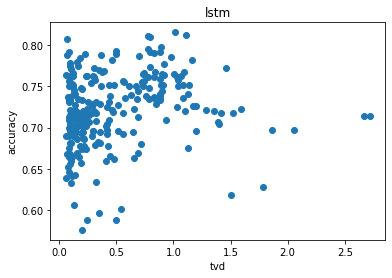

corrcoef = 0.171592


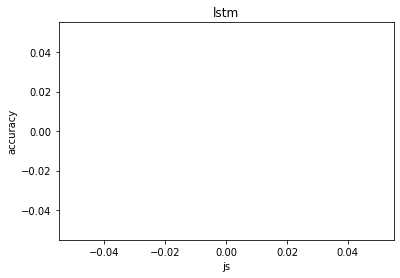

corrcoef = nan


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2449: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


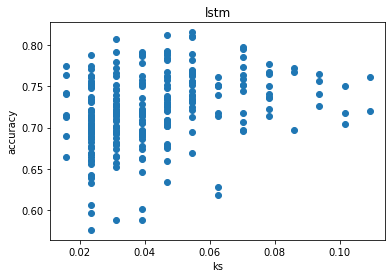

corrcoef = 0.291019


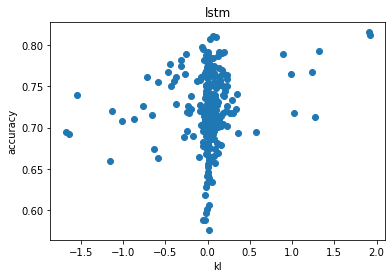

corrcoef = nan


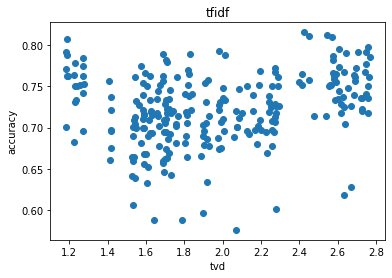

corrcoef = 0.226819


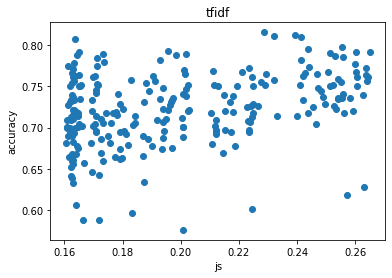

corrcoef = 0.330131


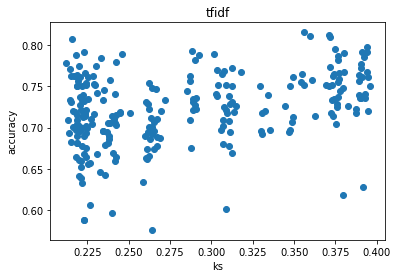

corrcoef = 0.353670


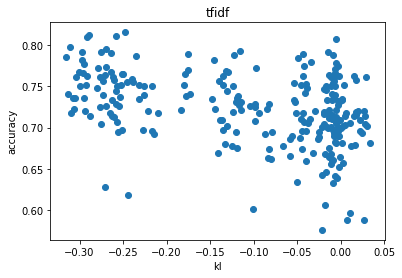

corrcoef = -0.392793


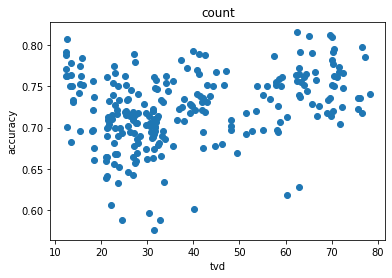

corrcoef = 0.305792


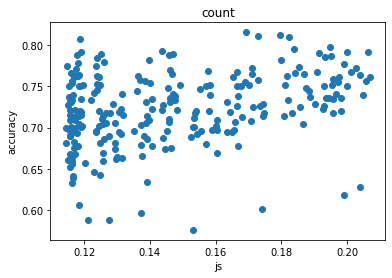

corrcoef = 0.312984


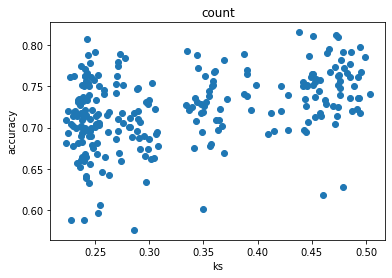

corrcoef = 0.379190


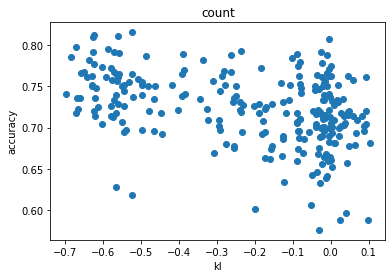

corrcoef = -0.394342
Error acc_metric=accuracy, data_type=prob, dis_metric=tvd
Error acc_metric=accuracy, data_type=prob, dis_metric=js
Error acc_metric=accuracy, data_type=prob, dis_metric=ks
Error acc_metric=accuracy, data_type=prob, dis_metric=kl


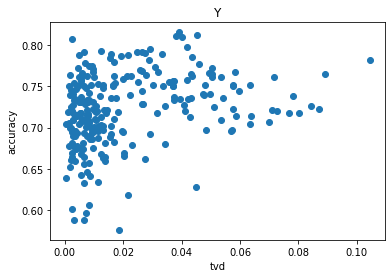

corrcoef = 0.292710


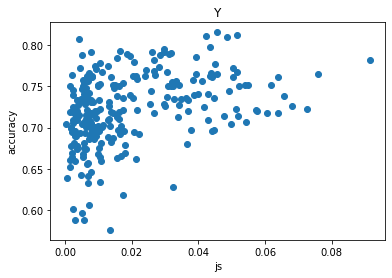

corrcoef = 0.381209


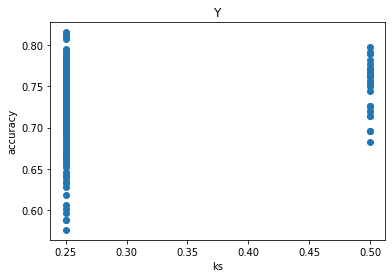

corrcoef = 0.195684


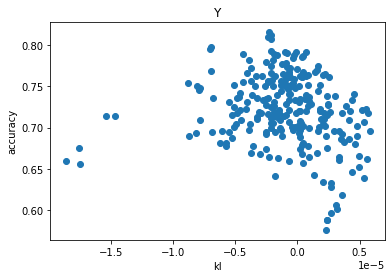

corrcoef = -0.158562


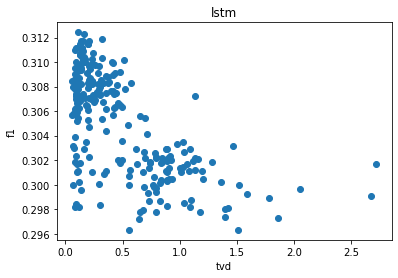

corrcoef = -0.630926


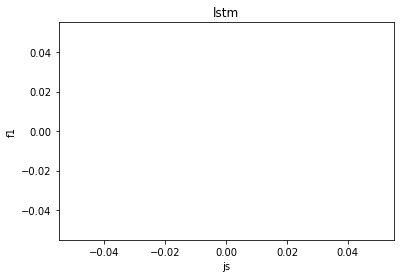

corrcoef = nan


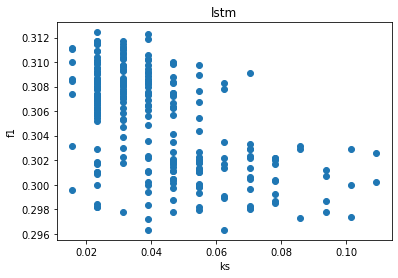

corrcoef = -0.546633


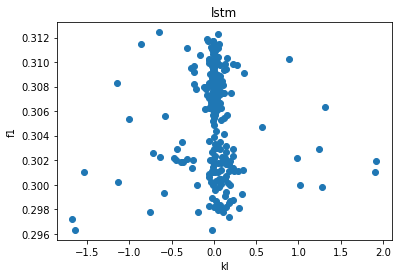

corrcoef = nan


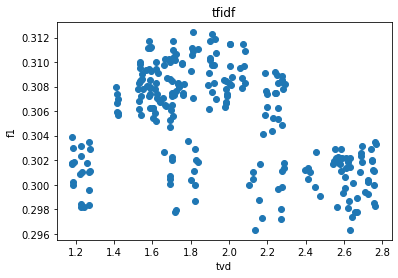

corrcoef = -0.376288


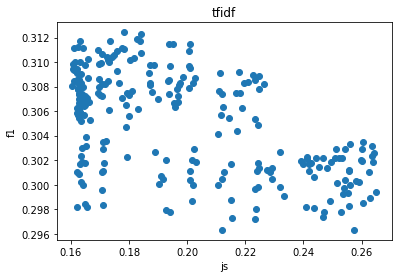

corrcoef = -0.556189


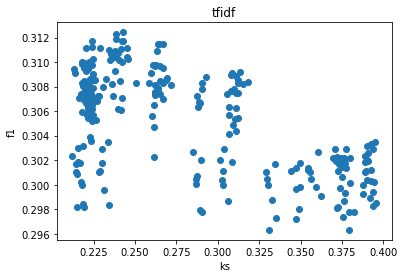

corrcoef = -0.614375


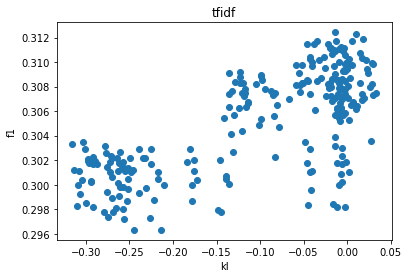

corrcoef = 0.706320


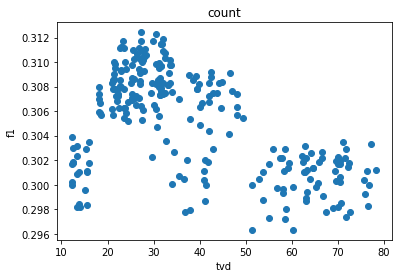

corrcoef = -0.545072


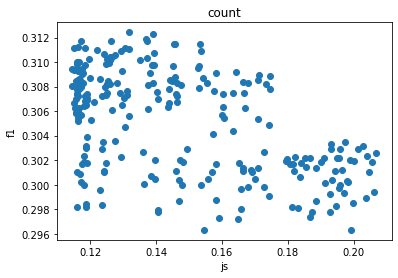

corrcoef = -0.523414


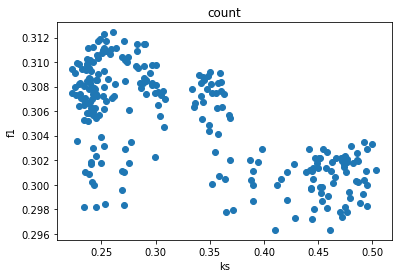

corrcoef = -0.677566


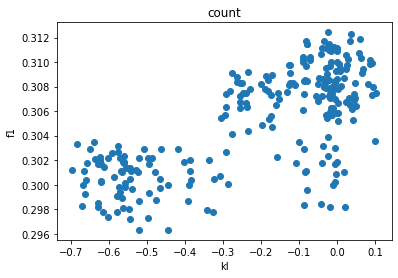

corrcoef = 0.710403
Error acc_metric=f1, data_type=prob, dis_metric=tvd
Error acc_metric=f1, data_type=prob, dis_metric=js
Error acc_metric=f1, data_type=prob, dis_metric=ks
Error acc_metric=f1, data_type=prob, dis_metric=kl


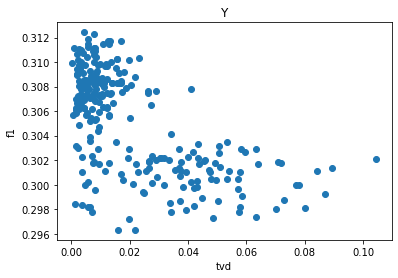

corrcoef = -0.612869


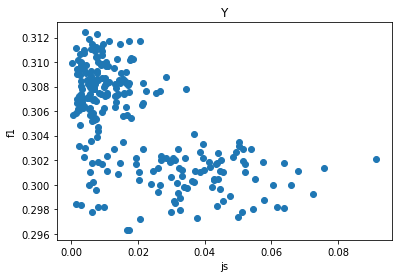

corrcoef = -0.616283


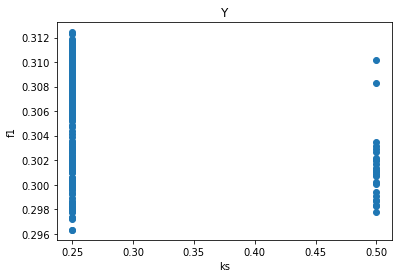

corrcoef = -0.297443


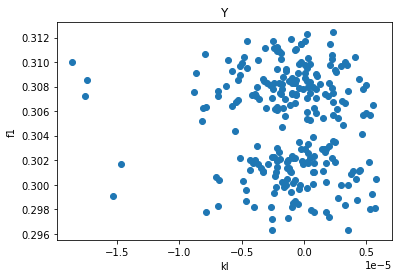

corrcoef = -0.086904


In [170]:
for acc_metric, data_type, dis_metric in product(['accuracy', 'f1'],
                                                 ['lstm', 'tfidf', 'count', 'prob', 'Y'],
                                                 ['tvd', 'js', 'ks', 'kl']):
    try:
        print('corrcoef = %f' % search_correlation(acc_metric, data_type, dis_metric))
    except:
        print(f'Error acc_metric={acc_metric}, data_type={data_type}, dis_metric={dis_metric}')

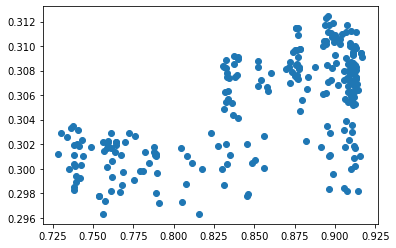

0.6439942058561328

In [172]:
search_correlation_old(df_perc_no_zero, df_f1)

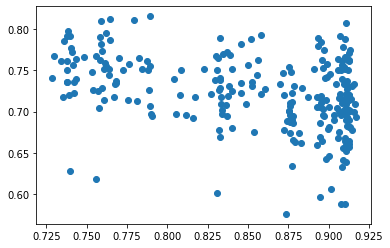

-0.3650620307529758

In [174]:
search_correlation_old(df_perc_no_zero, df_accuracy)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 300)         3000300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               186880    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 3,191,440
Trainable params: 191,140
Non-trainable params: 3,000,300
_________________________________________________________________
None


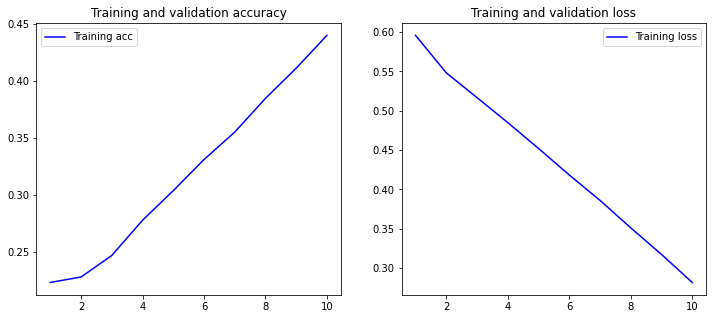

In [18]:
def plot_history(history):
    acc = history.history['fbeta']
#     val_acc = history.history['val_accuracy']
    loss = history.history['loss']
#     val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
#     plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
#     plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

print(model.summary())
plot_history(history)